<a href="https://colab.research.google.com/github/jonndoe/imagesNN/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Settings

In [0]:
default_content_image_url = "https://www.whitehouse.gov/wp-content/uploads/2017/11/President-Trump-Official-Portrait-200x200.jpg"
default_style_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

content_image_url = input("Enter the URL of your content image (leave blank for default: Donald Trump)") or default_content_image_url
style_image_url = input("Enter the URL of your style image. Leave blank for default: Starry Night)") or default_style_image_url

save_to_gdrive = False
save_user_input = input("Do you want to save your results to google drive? (y/n), default is no").lower()
if save_user_input in ["y", "yes"]:
  save_to_gdrive = True

if save_to_gdrive:
  # Google Colab PyTorch utilities
  !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
  import utils
  gsync = utils.GDriveSync()

# Download images
import requests

content_filename = content_image_url.split('/')[-1]
r = requests.get(content_image_url, allow_redirects=True)
open(content_filename, 'wb').write(r.content)

style_filename = style_image_url.split('/')[-1]
r = requests.get(style_image_url, allow_redirects=True)
open(style_filename, 'wb').write(r.content)

Enter the URL of your content image (leave blank for default: Donald Trump)https://i.imgur.com/ko3VcIO.jpg
Enter the URL of your style image. Leave blank for default: Starry Night)https://i.etsystatic.com/11278950/r/il/33a2d6/999139356/il_570xN.999139356_mgnj.jpg
Do you want to save your results to google drive? (y/n), default is noy
--2019-01-09 03:29:48--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   4.41K  --.-KB/s    in 0s      

2019-01-09 03:29:48 (58.8 MB/s) - ‘utils.py.2’ saved [4519/4519]



149723

# Imports and Installs

In [0]:
# Disable cell output
%%capture

print("Installing dependencies")

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

!pip install --no-cache-dir -I pillow

!pip install Pillow==4.0.0
!pip install PIL
!pip install image

# Non colab imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
print("Dependencies installed")

# Helper Functions

In [0]:
def load_image(img_path, max_size=400, shape=None):
    """Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims."""

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

# Helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# Download Pretrained VGG

In [0]:
# Get the "features" portion of VGG19
# The classifier portion is not needed for style transfer
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters
# Since only activations are measured for each conv layer
# Network weights aren't modified
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

# Load and Display Content and Style Images

Uploading file content_and_style.png: 100%|██████████| 100/100 [00:01<00:00, 60.88it/s]


File saved to Google Drive


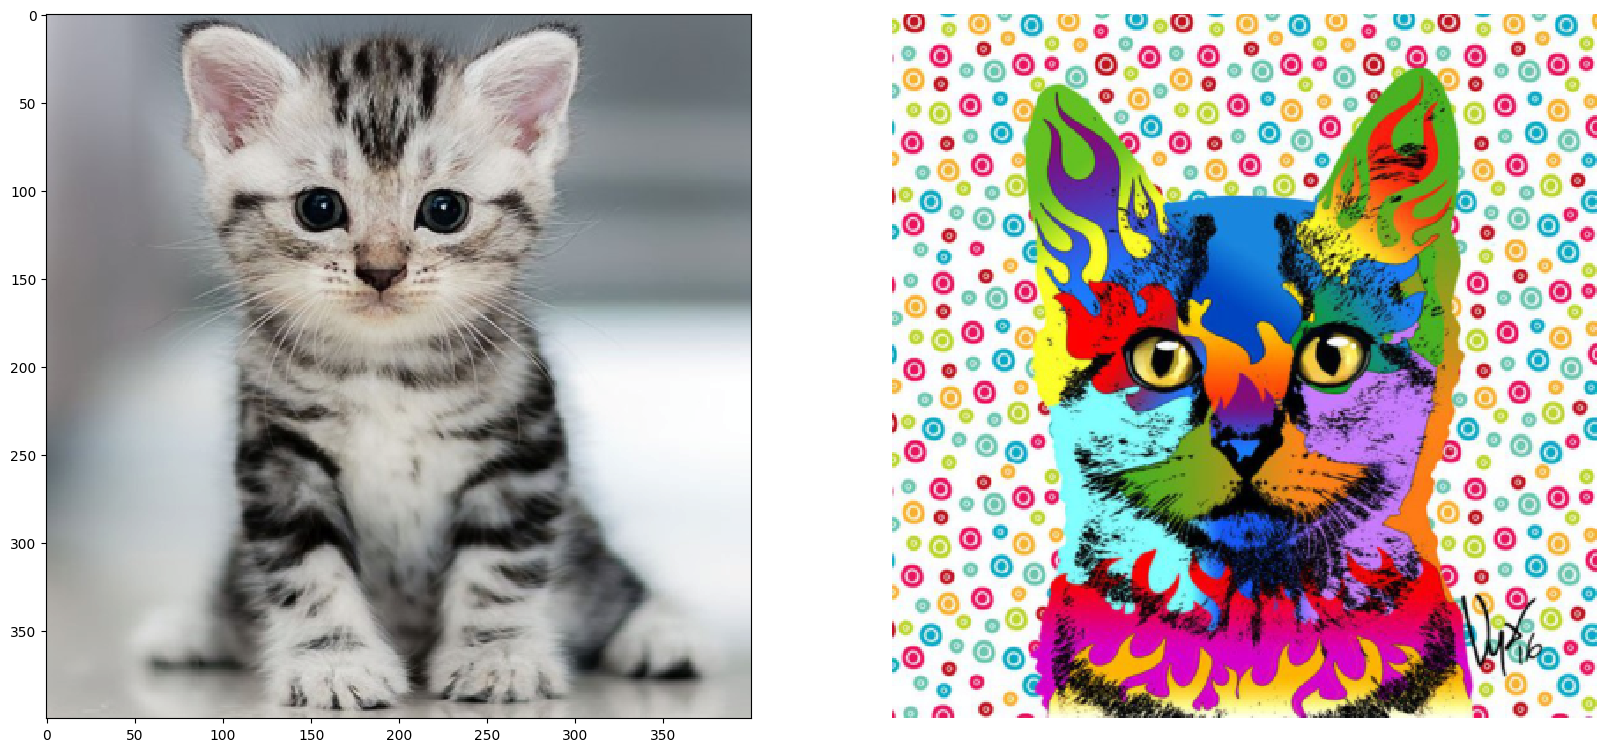

In [0]:
# Needed to make colab plots look nice
plt.style.use('default')


# Load in content and style image
content = load_image(content_filename).to(device)
# Resize style to match content, makes code easier
style = load_image(style_filename, shape=content.shape[-2:]).to(device)

# Display the content and style images side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
plt.axis('off')
ax2.imshow(im_convert(style))
plt.axis('off')
plt.savefig("content_and_style.png", bbox_inches='tight', pad_inches=0)

# Save plot to google drive
if save_to_gdrive:
  gsync.update_file_to_folder("content_and_style.png")
  print("File saved to Google Drive")
  
plt.show()

# Functions: Get Features and Gram Matrix

In [0]:
def get_features(image, model, layers=None):
    """ 
    Run an image forward through a model and get the features for
    a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    # Dictionary of layers needed from VGG for style transfer
    # Style representation is first conv layer from each block
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content representation
                  '28': 'conv5_1'}

    features = {}
    x = image.to(device)
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

def gram_matrix(tensor):
    """ 
    Calculate the Gram Matrix of a given tensor 
    """

    # Get the batch_size, depth, height, and width of the Tensor
    # Reshape it, so we're multiplying the features for each channel
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)

    # Calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

# Training Loop

In [0]:
# Get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image (copy of content iamge)
# This is the image that will have its style iteratively changed
target = content.clone().requires_grad_(True).to(device)

# Weights for each style layer
# Weighting earlier layers more will result in larger style artifacts
# conv4_2 is excluded because it is the content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# A higher style weight may make content unrecognizable
content_weight = 1  # alpha in paper
style_weight = 1e9  # beta in paper

# Show target image every x steps
show_every = 400

# Optimizer hyperparameters
optimizer = optim.Adam([target], lr=0.003)

# How many iterations to update content image
steps = 2000

print("Starting training...")
# Training Loop
for ii in range(1, steps+1):
    if ii % 100 == 0:
      print("Step #", ii, '/', steps)
      
    # Calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Initialize style loss to 0
    # The world was perfect before the model started training
    style_loss = 0
    
    # Iterate through each style layer and add to the style loss
    for layer in style_weights:
        # Get the target (goal) style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        # Calculate the target gram matrix
        target_gram = gram_matrix(target_features[layer])

        # Get the style representation
        style_gram = style_grams[layer]

        # Calculate the weighted style loss for one layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        # Add to the style loss
        style_loss += layer_style_loss / (d * h * w)


    #Calculate the total loss
    total_loss = (content_loss * content_weight) + (style_loss * style_weight)

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.savefig("result_" + str(ii) + ".png", bbox_inches='tight', pad_inches=0)
        if save_to_gdrive:
          print("File saved to Google Drive")
          gsync.update_file_to_folder("result_" + str(ii) + ".png")
        plt.show()


# Display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

plt.savefig("style_transfer.png", bbox_inches='tight', pad_inches=0)

if save_to_gdrive:
  print("Saved image to Google Drive")
  gsync.update_file_to_folder("style_transfer.png")
  
plt.show()
